<font size="5">Fashion-MNIST Multilayer Perceptron (TensorFlow)</font>

<br />

<u>Upcoming<u/>
- Improve Performance
  - Compare performance of Models 2 + 3 to Model 1 on most difficult classes
  - Build Model 4 (utilizing neuron dropout) & 5 ('Wide & Deep' model); evaluate effect on performance (e.g., convergence, error rate)
  - Tune hyperparameters (e.g., learning rate scheduling, neuron dropout rate) to speed convergence and improve accuracy
    - Use Keras Tuner for cross-validation

<br />

**Development/progress notes at bottom of analysis**

<br />

<u>Data/Task Notes<u/>
- Dataset contains 70,000 grayscale images of fashion items across 10 categories/classes, with information stored at the pixel level
  - Image dimensions are 28*28 pixels (784 total)
  - Data features consist of 784 pixel brightnesses (ranging from 0-255), with no colour (RGB/RGBA) information.
  - Data labels contain the true classification of each instance (integer encoding, 0-9).
- Since there is no emphasis on classifying any label in particular, and the full dataset conveniently includes equal proportions of all labels, train/validation/test sets are created with equal (stratified) proportions of instance labels.

In [2]:
#Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import product
from pathlib import Path
from time import strftime
import datetime
import random

%load_ext tensorboard

Section 1: DataFrame Transformations

In [3]:
#Import full CSV data as DataFrame
fmnist_full = pd.read_csv(r'C:\Users\darkw\Desktop\f_mnist_full.csv')
print(fmnist_full.shape)
fmnist_full.head(2)

(70000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#Verify dtypes
fmnist_full.dtypes[:5]

label     int64
pixel1    int64
pixel2    int64
pixel3    int64
pixel4    int64
dtype: object

In [5]:
#Establish indexed class list
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
#Sample 1a: Visualize record stored in full DataFrame
 #Select random df record
sample1a = fmnist_full.sample(1)
 #Output category from df
s1a_class = sample1a['label'].values[0]
print('Item clothing category:', class_names[s1a_class])
 #Preview index + attribute values
print(sample1a[['label','pixel18','pixel392','pixel750']])

Item clothing category: T-shirt/top
      label  pixel18  pixel392  pixel750
2571      0      126         0       252


In [7]:
 #Store sample features
sample1a = sample1a.drop(sample1a[['label']], axis=1)
s1a_vals = sample1a.values[0]
 #Reshape features for visualization
s1a_img = s1a_vals.reshape(28, 28)

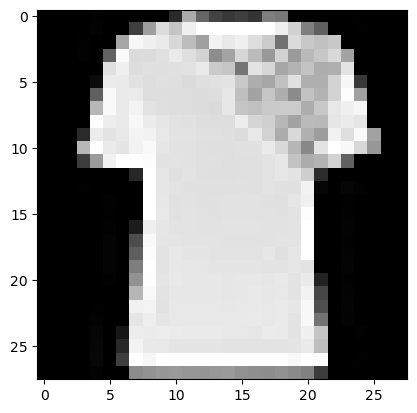

In [8]:
 #Display sample 1a in original cmap (grayscale)
plt.imshow(s1a_img, cmap='gray');

In [9]:
#Create target + feature dfs
y = fmnist_full['label']

X = fmnist_full.drop(fmnist_full[['label']], axis=1)
X.shape, y.shape

((70000, 784), (70000,))

In [10]:
#Review dataset balance
y.value_counts().sort_index()

label
0    7000
1    7000
2    7000
3    7000
4    7000
5    7000
6    7000
7    7000
8    7000
9    7000
Name: count, dtype: int64

In [11]:
#Convert target df to array
y = y.to_numpy()
y.shape

(70000,)

In [12]:
#Convert feature df to array + reshape for input layer
X_28 = X.to_numpy().reshape(70000, 28, 28)
X_28.shape

(70000, 28, 28)

Section 2: Array Transformations

In [13]:
#Sample 1b: Re-locate sample 1a in array; visualize to verify
 #Store 1a index value; output to verify
s1_index = sample1a.index
s1_index

Index([2571], dtype='int64')

In [14]:
 #Output category from label array
s1b_class = y[s1_index][0]

print('Item clothing category:', class_names[s1b_class])

Item clothing category: T-shirt/top


In [15]:
 #Store feature values from reshaped array
sample1b = X_28[s1_index][0]
 #Display integer dtype/values
print(sample1b.dtype)
sample1b[0][0:40]

int64


array([  0,   0,   0,   0,   2,   0,   0,   0,   0,   0,  42, 171, 102,
        67,  57,  63,  53, 126, 120,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int64)

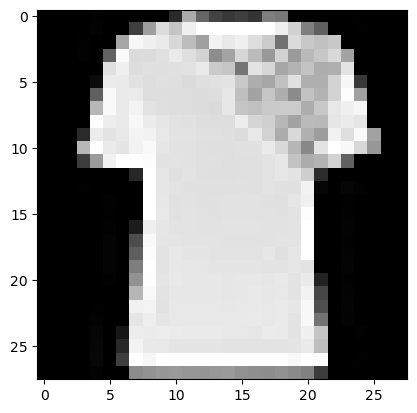

In [16]:
 #Display sample 1b in original cmap (grayscale)
plt.imshow(sample1b, cmap='gray');

In [17]:
#Split full dataset into 60,000 train + 10,000 test, maintaining label balance
X_train_full, X_te, y_train_full, y_te = train_test_split(X_28, y, test_size=1/7, stratify=y)

In [18]:
#Compare methods for creating validation set from training set
 #Keras training APIs include 'validation_split'; selects "the last samples in the x and y data provided, before shuffling"
  #Check last 5000 labels to evaluate would-be balance of validation set created by index slice/keras method
y_last5k = y_train_full[-5000:]

In [19]:
value1, count1 = np.unique(y_last5k, return_counts=True)

last5k_dict = dict(map(lambda label, freq : (label,freq) , value1, count1))

for i in last5k_dict:
    print(i, last5k_dict[i])

0 529
1 492
2 465
3 535
4 481
5 475
6 521
7 491
8 532
9 479


In [20]:
#Split training data into 55,000 train + 5,000 validation
 #Opting for sklearn 'train_test_split' to stratify by label, preserving label balance more precisely
X_train, X_valid, y_tr, y_val = train_test_split(X_train_full, y_train_full, test_size=1/12, stratify=y_train_full)

In [21]:
#Verify balance
 #Count label frequencies by set
value2, count2 = np.unique(y_tr, return_counts=True)
value3, count3 = np.unique(y_val, return_counts=True)
value4, count4 = np.unique(y_te, return_counts=True)

In [22]:
 #Map and display dictionaries
  #Training label frequencies
label_dict1 = dict(map(lambda label, freq : (label,freq) , value2, count2))

for i in label_dict1:
    print(i, label_dict1[i])

0 5500
1 5500
2 5500
3 5500
4 5500
5 5500
6 5500
7 5500
8 5500
9 5500


In [23]:
  #Validation label frequencies
label_dict2 = dict(map(lambda label, freq : (label,freq) , value3, count3))

for i in label_dict2:
    print(i, label_dict2[i])

0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500


In [24]:
  #Test label frequencies
label_dict3 = dict(map(lambda label, freq : (label,freq) , value4, count4))

for i in label_dict3:
    print(i, label_dict3[i])

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000


In [25]:
#Preview feature (pre-scaling) and label values from arrays
 #features
X_valid[:1][0][0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,  24, 139,  75,  69,
       163,  75,   0,   0,  32,  18,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int64)

In [26]:
 #label
y_val[:1]

array([1], dtype=int64)

In [27]:
#Scale feature arrays from 0-255 (int) to 0.0-1.0 (float)
X_tr_sc, X_val_sc, X_te_sc = X_train/255., X_valid/255., X_te/255.

In [28]:
#Check post-scaling dtypes
X_tr_sc.dtype, X_val_sc.dtype, X_te_sc.dtype

(dtype('float64'), dtype('float64'), dtype('float64'))

Section 3: Tensor transformations

In [29]:
#Convert feature + label sets to tensors; reduce respective precisions
X_tr_sc = tf.convert_to_tensor(X_tr_sc, dtype=tf.float32)
X_val_sc = tf.convert_to_tensor(X_val_sc, dtype=tf.float32)
X_te_sc = tf.convert_to_tensor(X_te_sc, dtype=tf.float32)

y_tr = tf.convert_to_tensor(y_tr, dtype=tf.int8)
y_val = tf.convert_to_tensor(y_val, dtype=tf.int8)
y_te = tf.convert_to_tensor(y_te, dtype=tf.int8)

In [30]:
 #Verify shapes
print(X_tr_sc.shape, y_tr.shape)
print(X_val_sc.shape, y_val.shape)
print(X_te_sc.shape, y_te.shape)

(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


In [31]:
#Sample 2: Visualize post-splits, post-scaling sample from tensor
sample2 = X_tr_sc[0]
 #Verify transformation of features to float dtype; preview values
print(sample2.dtype)
sample2[27]

<dtype: 'float32'>


<tf.Tensor: shape=(28,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [32]:
 #Output sample label + category from tensor
print(y_tr[0])

s2_class = y_tr[0]
print(class_names[s2_class])

tf.Tensor(8, shape=(), dtype=int8)
Bag


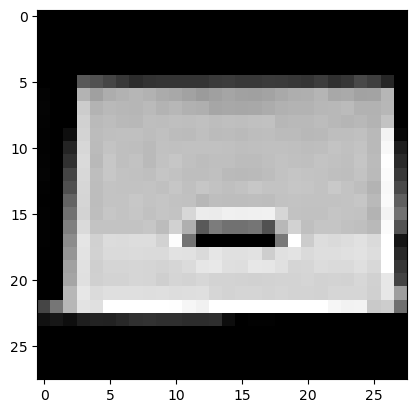

In [33]:
 #Display sample 2
plt.imshow(sample2, cmap='gray');

Section 4: Model Building, Training & Storage

In [34]:
#TensorBoard log directory setup
log_dir1 = "Tf_output/fit/FMNIST/DNN1_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir2 = "Tf_output/fit/FMNIST/DNN2_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir3 = "Tf_output/fit/FMNIST/DNN3_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#Define callbacks
 #Event log callbacks
event_cb1 = tf.keras.callbacks.TensorBoard(log_dir=log_dir1, histogram_freq=1)
event_cb2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)
event_cb3 = tf.keras.callbacks.TensorBoard(log_dir=log_dir3, histogram_freq=1)
 #Model checkpoint callback
checkp_cb1 = tf.keras.callbacks.ModelCheckpoint("Tf_output/checkpoints/FMNIST/DNN1", save_best_only=True)
checkp_cb2 = tf.keras.callbacks.ModelCheckpoint("Tf_output/checkpoints/FMNIST/DNN2", save_best_only=True)
checkp_cb3 = tf.keras.callbacks.ModelCheckpoint("Tf_output/checkpoints/FMNIST/DNN3", save_best_only=True)
 #Early stopping callback
stop_cb1 = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, start_from_epoch=20)
stop_cb2 = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, start_from_epoch=20)
stop_cb3 = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, start_from_epoch=20)

#Bundle
cb_list1 = [event_cb1, checkp_cb1, stop_cb1]
cb_list2 = [event_cb2, checkp_cb2, stop_cb2]
cb_list3 = [event_cb3, checkp_cb3, stop_cb3]

In [36]:
#Build Network 1
 #2 hidden layers (300 * 100 nodes)
dnn1 = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=[28,28]),
tf.keras.layers.Dense(300, activation='relu'),
tf.keras.layers.Dense(100, activation='relu'),
tf.keras.layers.Dense(10, activation='softmax')
])

dnn1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
#Build Network 2
 #2 hidden layers (200*200 nodes)
dnn2 = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=[28,28]),
tf.keras.layers.Dense(200, activation='relu'),
tf.keras.layers.Dense(200, activation='relu'),
tf.keras.layers.Dense(10, activation='softmax')
])

dnn2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 200)               157000    
                                                                 
 dense_7 (Dense)             (None, 200)               40200     
                                                                 
 dense_8 (Dense)             (None, 10)                2010      
                                                                 
Total params: 199210 (778.16 KB)
Trainable params: 199210 (778.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
#Build Network 3
 #3 hidden layers (134*133*133 nodes)
dnn3 = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=[28,28]),
tf.keras.layers.Dense(134, activation='relu'),
tf.keras.layers.Dense(133, activation='relu'),
tf.keras.layers.Dense(133, activation='relu'),
tf.keras.layers.Dense(10, activation='softmax')
])

dnn3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 134)               105190    
                                                                 
 dense_10 (Dense)            (None, 133)               17955     
                                                                 
 dense_11 (Dense)            (None, 133)               17822     
                                                                 
 dense_12 (Dense)            (None, 10)                1340      
                                                                 
Total params: 142307 (555.89 KB)
Trainable params: 142307 (555.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
#Preview initialized trainable parameters (weights and biases) for third layer of Model 1
 #Access + store third layer (second dense; 100 neurons)
layer_100node = dnn1.layers[2]
layer_100node.name

'dense_4'

In [40]:
 #Store trainable parameters (30,000 weights, 100 biases)
weights_100, biases_100 = layer_100node.get_weights()

 #For densely connected layer, shape of 2-dimensional array containing weights between every neuron of previous (input) and selected layer 
print(weights_100.shape)
 #Preview array of randomly initialized weights
weights_100

(300, 100)


array([[-0.01221219, -0.0458186 ,  0.04060278, ..., -0.0804995 ,
        -0.0611033 , -0.07636233],
       [-0.05465429,  0.05876713,  0.00707337, ...,  0.0607124 ,
        -0.07183598,  0.06870142],
       [-0.03328469,  0.09443804,  0.06425818, ..., -0.06344586,
         0.02498611,  0.03929476],
       ...,
       [ 0.12101927, -0.02636217, -0.01670009, ..., -0.01263317,
         0.07374453, -0.07278922],
       [-0.11375356,  0.03746565,  0.08539381, ...,  0.05697871,
        -0.01650298,  0.09480479],
       [-0.07233766,  0.09010301, -0.07001202, ...,  0.03208073,
         0.05834406, -0.01328249]], dtype=float32)

In [41]:
print(biases_100.shape)
 #Output untrained biases for each neuron
biases_100

(100,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [42]:
#Configure optimizers, loss functions & performance metrics
optimizer1 = tf.keras.optimizers.SGD() #default: 0.01
optimizer2 = tf.keras.optimizers.SGD()
optimizer3 = tf.keras.optimizers.SGD()

dnn1.compile(loss='sparse_categorical_crossentropy',
                   optimizer=optimizer1,
                   metrics=['accuracy'])

dnn2.compile(loss='sparse_categorical_crossentropy',
                   optimizer=optimizer2,
                   metrics=['accuracy'])

dnn3.compile(loss='sparse_categorical_crossentropy',
                   optimizer=optimizer3,
                   metrics=['accuracy'])

In [44]:
#Train networks + store results
epoch_count = 50

 #Train Model 1
history1 = dnn1.fit(X_tr_sc, y_tr, epochs=epoch_count, validation_data=(X_val_sc, y_val), callbacks=cb_list1, verbose=2)

Epoch 1/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


1719/1719 - 3s - loss: 0.6264 - accuracy: 0.7883 - val_loss: 0.5271 - val_accuracy: 0.8164 - 3s/epoch - 2ms/step
Epoch 2/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


1719/1719 - 3s - loss: 0.4861 - accuracy: 0.8308 - val_loss: 0.4616 - val_accuracy: 0.8424 - 3s/epoch - 2ms/step
Epoch 3/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


1719/1719 - 3s - loss: 0.4439 - accuracy: 0.8447 - val_loss: 0.4224 - val_accuracy: 0.8524 - 3s/epoch - 2ms/step
Epoch 4/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


1719/1719 - 3s - loss: 0.4187 - accuracy: 0.8521 - val_loss: 0.4035 - val_accuracy: 0.8580 - 3s/epoch - 2ms/step
Epoch 5/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


1719/1719 - 3s - loss: 0.3993 - accuracy: 0.8600 - val_loss: 0.4001 - val_accuracy: 0.8582 - 3s/epoch - 2ms/step
Epoch 6/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


1719/1719 - 3s - loss: 0.3828 - accuracy: 0.8649 - val_loss: 0.3759 - val_accuracy: 0.8716 - 3s/epoch - 2ms/step
Epoch 7/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


1719/1719 - 3s - loss: 0.3695 - accuracy: 0.8695 - val_loss: 0.3682 - val_accuracy: 0.8748 - 3s/epoch - 2ms/step
Epoch 8/50
1719/1719 - 3s - loss: 0.3580 - accuracy: 0.8732 - val_loss: 0.3787 - val_accuracy: 0.8728 - 3s/epoch - 2ms/step
Epoch 9/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


1719/1719 - 3s - loss: 0.3469 - accuracy: 0.8775 - val_loss: 0.3617 - val_accuracy: 0.8752 - 3s/epoch - 2ms/step
Epoch 10/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


1719/1719 - 3s - loss: 0.3373 - accuracy: 0.8793 - val_loss: 0.3579 - val_accuracy: 0.8730 - 3s/epoch - 2ms/step
Epoch 11/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


1719/1719 - 3s - loss: 0.3288 - accuracy: 0.8826 - val_loss: 0.3527 - val_accuracy: 0.8780 - 3s/epoch - 2ms/step
Epoch 12/50
1719/1719 - 3s - loss: 0.3209 - accuracy: 0.8857 - val_loss: 0.3780 - val_accuracy: 0.8674 - 3s/epoch - 2ms/step
Epoch 13/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


1719/1719 - 3s - loss: 0.3144 - accuracy: 0.8883 - val_loss: 0.3394 - val_accuracy: 0.8804 - 3s/epoch - 2ms/step
Epoch 14/50
1719/1719 - 3s - loss: 0.3068 - accuracy: 0.8900 - val_loss: 0.3637 - val_accuracy: 0.8706 - 3s/epoch - 2ms/step
Epoch 15/50
1719/1719 - 3s - loss: 0.3003 - accuracy: 0.8921 - val_loss: 0.3432 - val_accuracy: 0.8788 - 3s/epoch - 2ms/step
Epoch 16/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


1719/1719 - 3s - loss: 0.2949 - accuracy: 0.8937 - val_loss: 0.3285 - val_accuracy: 0.8864 - 3s/epoch - 2ms/step
Epoch 17/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


1719/1719 - 3s - loss: 0.2885 - accuracy: 0.8974 - val_loss: 0.3221 - val_accuracy: 0.8882 - 3s/epoch - 2ms/step
Epoch 18/50
1719/1719 - 3s - loss: 0.2831 - accuracy: 0.8986 - val_loss: 0.3310 - val_accuracy: 0.8842 - 3s/epoch - 2ms/step
Epoch 19/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


1719/1719 - 3s - loss: 0.2775 - accuracy: 0.8998 - val_loss: 0.3176 - val_accuracy: 0.8892 - 3s/epoch - 2ms/step
Epoch 20/50
1719/1719 - 3s - loss: 0.2728 - accuracy: 0.9030 - val_loss: 0.3329 - val_accuracy: 0.8856 - 3s/epoch - 2ms/step
Epoch 21/50
1719/1719 - 3s - loss: 0.2675 - accuracy: 0.9039 - val_loss: 0.3216 - val_accuracy: 0.8840 - 3s/epoch - 2ms/step
Epoch 22/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


1719/1719 - 3s - loss: 0.2632 - accuracy: 0.9048 - val_loss: 0.3085 - val_accuracy: 0.8916 - 3s/epoch - 2ms/step
Epoch 23/50
1719/1719 - 3s - loss: 0.2583 - accuracy: 0.9070 - val_loss: 0.3259 - val_accuracy: 0.8810 - 3s/epoch - 2ms/step
Epoch 24/50
1719/1719 - 3s - loss: 0.2536 - accuracy: 0.9094 - val_loss: 0.3264 - val_accuracy: 0.8888 - 3s/epoch - 2ms/step
Epoch 25/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


1719/1719 - 3s - loss: 0.2502 - accuracy: 0.9101 - val_loss: 0.3056 - val_accuracy: 0.8944 - 3s/epoch - 2ms/step
Epoch 26/50
1719/1719 - 3s - loss: 0.2453 - accuracy: 0.9117 - val_loss: 0.3088 - val_accuracy: 0.8926 - 3s/epoch - 2ms/step
Epoch 27/50
1719/1719 - 3s - loss: 0.2413 - accuracy: 0.9130 - val_loss: 0.3229 - val_accuracy: 0.8846 - 3s/epoch - 2ms/step
Epoch 28/50
1719/1719 - 3s - loss: 0.2377 - accuracy: 0.9152 - val_loss: 0.3076 - val_accuracy: 0.8920 - 3s/epoch - 2ms/step
Epoch 29/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


1719/1719 - 3s - loss: 0.2340 - accuracy: 0.9158 - val_loss: 0.3019 - val_accuracy: 0.8946 - 3s/epoch - 2ms/step
Epoch 30/50
1719/1719 - 3s - loss: 0.2305 - accuracy: 0.9183 - val_loss: 0.3194 - val_accuracy: 0.8884 - 3s/epoch - 2ms/step
Epoch 31/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN1\assets


1719/1719 - 3s - loss: 0.2268 - accuracy: 0.9185 - val_loss: 0.2928 - val_accuracy: 0.8994 - 3s/epoch - 2ms/step
Epoch 32/50
1719/1719 - 3s - loss: 0.2226 - accuracy: 0.9192 - val_loss: 0.3077 - val_accuracy: 0.8918 - 3s/epoch - 2ms/step
Epoch 33/50
1719/1719 - 3s - loss: 0.2183 - accuracy: 0.9217 - val_loss: 0.3057 - val_accuracy: 0.8926 - 3s/epoch - 2ms/step
Epoch 34/50
1719/1719 - 3s - loss: 0.2160 - accuracy: 0.9226 - val_loss: 0.2949 - val_accuracy: 0.8996 - 3s/epoch - 2ms/step
Epoch 35/50
1719/1719 - 3s - loss: 0.2127 - accuracy: 0.9238 - val_loss: 0.3015 - val_accuracy: 0.8934 - 3s/epoch - 2ms/step
Epoch 36/50
1719/1719 - 3s - loss: 0.2092 - accuracy: 0.9243 - val_loss: 0.3038 - val_accuracy: 0.8966 - 3s/epoch - 2ms/step


In [45]:
 #Train Model 2
history2 = dnn2.fit(X_tr_sc, y_tr, epochs=epoch_count, validation_data=(X_val_sc, y_val), callbacks=cb_list2, verbose=2)

Epoch 1/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.7384 - accuracy: 0.7578 - val_loss: 0.5554 - val_accuracy: 0.8100 - 3s/epoch - 2ms/step
Epoch 2/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.4988 - accuracy: 0.8262 - val_loss: 0.4826 - val_accuracy: 0.8288 - 3s/epoch - 2ms/step
Epoch 3/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.4537 - accuracy: 0.8415 - val_loss: 0.4314 - val_accuracy: 0.8538 - 3s/epoch - 2ms/step
Epoch 4/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.4272 - accuracy: 0.8519 - val_loss: 0.4197 - val_accuracy: 0.8560 - 3s/epoch - 2ms/step
Epoch 5/50
1719/1719 - 3s - loss: 0.4079 - accuracy: 0.8572 - val_loss: 0.4442 - val_accuracy: 0.8420 - 3s/epoch - 2ms/step
Epoch 6/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.3926 - accuracy: 0.8622 - val_loss: 0.3921 - val_accuracy: 0.8670 - 3s/epoch - 2ms/step
Epoch 7/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.3787 - accuracy: 0.8679 - val_loss: 0.3720 - val_accuracy: 0.8734 - 3s/epoch - 2ms/step
Epoch 8/50
1719/1719 - 3s - loss: 0.3674 - accuracy: 0.8714 - val_loss: 0.3735 - val_accuracy: 0.8770 - 3s/epoch - 1ms/step
Epoch 9/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.3559 - accuracy: 0.8745 - val_loss: 0.3657 - val_accuracy: 0.8752 - 3s/epoch - 2ms/step
Epoch 10/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.3475 - accuracy: 0.8778 - val_loss: 0.3545 - val_accuracy: 0.8780 - 3s/epoch - 2ms/step
Epoch 11/50
1719/1719 - 3s - loss: 0.3375 - accuracy: 0.8817 - val_loss: 0.3641 - val_accuracy: 0.8710 - 3s/epoch - 1ms/step
Epoch 12/50
1719/1719 - 3s - loss: 0.3299 - accuracy: 0.8832 - val_loss: 0.3761 - val_accuracy: 0.8708 - 3s/epoch - 1ms/step
Epoch 13/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.3225 - accuracy: 0.8869 - val_loss: 0.3492 - val_accuracy: 0.8798 - 3s/epoch - 2ms/step
Epoch 14/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.3160 - accuracy: 0.8875 - val_loss: 0.3349 - val_accuracy: 0.8834 - 3s/epoch - 2ms/step
Epoch 15/50
1719/1719 - 3s - loss: 0.3094 - accuracy: 0.8894 - val_loss: 0.3409 - val_accuracy: 0.8798 - 3s/epoch - 1ms/step
Epoch 16/50
1719/1719 - 3s - loss: 0.3035 - accuracy: 0.8925 - val_loss: 0.3365 - val_accuracy: 0.8830 - 3s/epoch - 2ms/step
Epoch 17/50
1719/1719 - 3s - loss: 0.2967 - accuracy: 0.8947 - val_loss: 0.3432 - val_accuracy: 0.8812 - 3s/epoch - 2ms/step
Epoch 18/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.2908 - accuracy: 0.8948 - val_loss: 0.3276 - val_accuracy: 0.8858 - 3s/epoch - 2ms/step
Epoch 19/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.2847 - accuracy: 0.8991 - val_loss: 0.3220 - val_accuracy: 0.8886 - 3s/epoch - 2ms/step
Epoch 20/50
1719/1719 - 3s - loss: 0.2802 - accuracy: 0.9002 - val_loss: 0.3276 - val_accuracy: 0.8860 - 3s/epoch - 2ms/step
Epoch 21/50
1719/1719 - 3s - loss: 0.2747 - accuracy: 0.9016 - val_loss: 0.3225 - val_accuracy: 0.8866 - 3s/epoch - 1ms/step
Epoch 22/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.2700 - accuracy: 0.9039 - val_loss: 0.3128 - val_accuracy: 0.8870 - 3s/epoch - 2ms/step
Epoch 23/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.2654 - accuracy: 0.9052 - val_loss: 0.3118 - val_accuracy: 0.8914 - 3s/epoch - 2ms/step
Epoch 24/50
1719/1719 - 3s - loss: 0.2614 - accuracy: 0.9072 - val_loss: 0.3252 - val_accuracy: 0.8858 - 3s/epoch - 2ms/step
Epoch 25/50
1719/1719 - 3s - loss: 0.2572 - accuracy: 0.9086 - val_loss: 0.3200 - val_accuracy: 0.8886 - 3s/epoch - 1ms/step
Epoch 26/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.2527 - accuracy: 0.9099 - val_loss: 0.3105 - val_accuracy: 0.8934 - 3s/epoch - 2ms/step
Epoch 27/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.2490 - accuracy: 0.9110 - val_loss: 0.3067 - val_accuracy: 0.8928 - 3s/epoch - 2ms/step
Epoch 28/50
1719/1719 - 3s - loss: 0.2447 - accuracy: 0.9119 - val_loss: 0.3153 - val_accuracy: 0.8898 - 3s/epoch - 1ms/step
Epoch 29/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.2413 - accuracy: 0.9132 - val_loss: 0.3018 - val_accuracy: 0.8918 - 3s/epoch - 2ms/step
Epoch 30/50
1719/1719 - 3s - loss: 0.2366 - accuracy: 0.9146 - val_loss: 0.3297 - val_accuracy: 0.8862 - 3s/epoch - 2ms/step
Epoch 31/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.2350 - accuracy: 0.9160 - val_loss: 0.3011 - val_accuracy: 0.8950 - 3s/epoch - 2ms/step
Epoch 32/50
1719/1719 - 3s - loss: 0.2303 - accuracy: 0.9178 - val_loss: 0.3096 - val_accuracy: 0.8898 - 3s/epoch - 1ms/step
Epoch 33/50
1719/1719 - 3s - loss: 0.2271 - accuracy: 0.9192 - val_loss: 0.3035 - val_accuracy: 0.8912 - 3s/epoch - 1ms/step
Epoch 34/50
1719/1719 - 3s - loss: 0.2246 - accuracy: 0.9196 - val_loss: 0.3147 - val_accuracy: 0.8902 - 3s/epoch - 1ms/step
Epoch 35/50
1719/1719 - 3s - loss: 0.2203 - accuracy: 0.9215 - val_loss: 0.3033 - val_accuracy: 0.8946 - 3s/epoch - 1ms/step
Epoch 36/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.2181 - accuracy: 0.9206 - val_loss: 0.2961 - val_accuracy: 0.8966 - 3s/epoch - 2ms/step
Epoch 37/50
1719/1719 - 3s - loss: 0.2148 - accuracy: 0.9224 - val_loss: 0.2982 - val_accuracy: 0.8980 - 3s/epoch - 1ms/step
Epoch 38/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.2116 - accuracy: 0.9249 - val_loss: 0.2938 - val_accuracy: 0.8992 - 3s/epoch - 2ms/step
Epoch 39/50
1719/1719 - 3s - loss: 0.2079 - accuracy: 0.9257 - val_loss: 0.2985 - val_accuracy: 0.8976 - 3s/epoch - 1ms/step
Epoch 40/50
1719/1719 - 3s - loss: 0.2042 - accuracy: 0.9268 - val_loss: 0.3339 - val_accuracy: 0.8824 - 3s/epoch - 1ms/step
Epoch 41/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN2\assets


1719/1719 - 3s - loss: 0.2020 - accuracy: 0.9265 - val_loss: 0.2917 - val_accuracy: 0.9006 - 3s/epoch - 2ms/step
Epoch 42/50
1719/1719 - 3s - loss: 0.1993 - accuracy: 0.9293 - val_loss: 0.3069 - val_accuracy: 0.8934 - 3s/epoch - 2ms/step
Epoch 43/50
1719/1719 - 3s - loss: 0.1966 - accuracy: 0.9303 - val_loss: 0.2926 - val_accuracy: 0.8992 - 3s/epoch - 1ms/step
Epoch 44/50
1719/1719 - 2s - loss: 0.1939 - accuracy: 0.9311 - val_loss: 0.3062 - val_accuracy: 0.8942 - 2s/epoch - 1ms/step
Epoch 45/50
1719/1719 - 2s - loss: 0.1912 - accuracy: 0.9308 - val_loss: 0.3222 - val_accuracy: 0.8854 - 2s/epoch - 1ms/step
Epoch 46/50
1719/1719 - 3s - loss: 0.1886 - accuracy: 0.9326 - val_loss: 0.3271 - val_accuracy: 0.8950 - 3s/epoch - 1ms/step


In [46]:
 #Train Model 3
history3 = dnn3.fit(X_tr_sc, y_tr, epochs=epoch_count, validation_data=(X_val_sc, y_val), callbacks=cb_list3, verbose=2)

Epoch 1/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


1719/1719 - 3s - loss: 0.7586 - accuracy: 0.7419 - val_loss: 0.5937 - val_accuracy: 0.7950 - 3s/epoch - 2ms/step
Epoch 2/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


1719/1719 - 3s - loss: 0.4983 - accuracy: 0.8270 - val_loss: 0.4510 - val_accuracy: 0.8452 - 3s/epoch - 2ms/step
Epoch 3/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


1719/1719 - 3s - loss: 0.4473 - accuracy: 0.8438 - val_loss: 0.4199 - val_accuracy: 0.8528 - 3s/epoch - 2ms/step
Epoch 4/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


1719/1719 - 3s - loss: 0.4167 - accuracy: 0.8532 - val_loss: 0.4175 - val_accuracy: 0.8576 - 3s/epoch - 2ms/step
Epoch 5/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


1719/1719 - 3s - loss: 0.3949 - accuracy: 0.8595 - val_loss: 0.3744 - val_accuracy: 0.8730 - 3s/epoch - 2ms/step
Epoch 6/50
1719/1719 - 2s - loss: 0.3774 - accuracy: 0.8661 - val_loss: 0.3890 - val_accuracy: 0.8602 - 2s/epoch - 1ms/step
Epoch 7/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


1719/1719 - 3s - loss: 0.3630 - accuracy: 0.8707 - val_loss: 0.3630 - val_accuracy: 0.8724 - 3s/epoch - 2ms/step
Epoch 8/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


1719/1719 - 3s - loss: 0.3512 - accuracy: 0.8746 - val_loss: 0.3547 - val_accuracy: 0.8742 - 3s/epoch - 2ms/step
Epoch 9/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


1719/1719 - 3s - loss: 0.3410 - accuracy: 0.8786 - val_loss: 0.3489 - val_accuracy: 0.8764 - 3s/epoch - 2ms/step
Epoch 10/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


1719/1719 - 3s - loss: 0.3309 - accuracy: 0.8819 - val_loss: 0.3473 - val_accuracy: 0.8754 - 3s/epoch - 2ms/step
Epoch 11/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


1719/1719 - 3s - loss: 0.3225 - accuracy: 0.8850 - val_loss: 0.3434 - val_accuracy: 0.8788 - 3s/epoch - 2ms/step
Epoch 12/50
1719/1719 - 2s - loss: 0.3146 - accuracy: 0.8870 - val_loss: 0.3509 - val_accuracy: 0.8756 - 2s/epoch - 1ms/step
Epoch 13/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


1719/1719 - 3s - loss: 0.3081 - accuracy: 0.8900 - val_loss: 0.3394 - val_accuracy: 0.8786 - 3s/epoch - 2ms/step
Epoch 14/50
1719/1719 - 2s - loss: 0.2999 - accuracy: 0.8920 - val_loss: 0.3461 - val_accuracy: 0.8732 - 2s/epoch - 1ms/step
Epoch 15/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


1719/1719 - 3s - loss: 0.2949 - accuracy: 0.8934 - val_loss: 0.3247 - val_accuracy: 0.8838 - 3s/epoch - 2ms/step
Epoch 16/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


1719/1719 - 3s - loss: 0.2888 - accuracy: 0.8949 - val_loss: 0.3137 - val_accuracy: 0.8878 - 3s/epoch - 2ms/step
Epoch 17/50
1719/1719 - 2s - loss: 0.2826 - accuracy: 0.8967 - val_loss: 0.3140 - val_accuracy: 0.8860 - 2s/epoch - 1ms/step
Epoch 18/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


1719/1719 - 3s - loss: 0.2769 - accuracy: 0.8999 - val_loss: 0.3123 - val_accuracy: 0.8908 - 3s/epoch - 2ms/step
Epoch 19/50
1719/1719 - 3s - loss: 0.2725 - accuracy: 0.9011 - val_loss: 0.3365 - val_accuracy: 0.8788 - 3s/epoch - 1ms/step
Epoch 20/50
1719/1719 - 2s - loss: 0.2658 - accuracy: 0.9041 - val_loss: 0.3157 - val_accuracy: 0.8892 - 2s/epoch - 1ms/step
Epoch 21/50
1719/1719 - 2s - loss: 0.2617 - accuracy: 0.9049 - val_loss: 0.3151 - val_accuracy: 0.8928 - 2s/epoch - 1ms/step
Epoch 22/50
1719/1719 - 2s - loss: 0.2574 - accuracy: 0.9068 - val_loss: 0.3249 - val_accuracy: 0.8868 - 2s/epoch - 1ms/step
Epoch 23/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


1719/1719 - 3s - loss: 0.2526 - accuracy: 0.9090 - val_loss: 0.3107 - val_accuracy: 0.8916 - 3s/epoch - 2ms/step
Epoch 24/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


1719/1719 - 3s - loss: 0.2484 - accuracy: 0.9096 - val_loss: 0.3083 - val_accuracy: 0.8922 - 3s/epoch - 2ms/step
Epoch 25/50
1719/1719 - 3s - loss: 0.2438 - accuracy: 0.9114 - val_loss: 0.3111 - val_accuracy: 0.8922 - 3s/epoch - 1ms/step
Epoch 26/50
1719/1719 - 2s - loss: 0.2396 - accuracy: 0.9125 - val_loss: 0.3084 - val_accuracy: 0.8908 - 2s/epoch - 1ms/step
Epoch 27/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


1719/1719 - 3s - loss: 0.2362 - accuracy: 0.9140 - val_loss: 0.3076 - val_accuracy: 0.8908 - 3s/epoch - 2ms/step
Epoch 28/50
1719/1719 - 2s - loss: 0.2317 - accuracy: 0.9152 - val_loss: 0.3080 - val_accuracy: 0.8888 - 2s/epoch - 1ms/step
Epoch 29/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\DNN3\assets


1719/1719 - 3s - loss: 0.2275 - accuracy: 0.9169 - val_loss: 0.2973 - val_accuracy: 0.8960 - 3s/epoch - 2ms/step
Epoch 30/50
1719/1719 - 2s - loss: 0.2244 - accuracy: 0.9179 - val_loss: 0.2975 - val_accuracy: 0.8930 - 2s/epoch - 1ms/step
Epoch 31/50
1719/1719 - 3s - loss: 0.2209 - accuracy: 0.9188 - val_loss: 0.3021 - val_accuracy: 0.8942 - 3s/epoch - 2ms/step
Epoch 32/50
1719/1719 - 2s - loss: 0.2172 - accuracy: 0.9209 - val_loss: 0.3244 - val_accuracy: 0.8928 - 2s/epoch - 1ms/step
Epoch 33/50
1719/1719 - 2s - loss: 0.2135 - accuracy: 0.9222 - val_loss: 0.2986 - val_accuracy: 0.8972 - 2s/epoch - 1ms/step
Epoch 34/50
1719/1719 - 2s - loss: 0.2090 - accuracy: 0.9235 - val_loss: 0.3157 - val_accuracy: 0.8912 - 2s/epoch - 1ms/step


In [47]:
#Preview post-training parameters for previously accessed (third) Model 1 layer
weights_100_tr, biases_100_tr = layer_100node.get_weights()
 #Trained weights
weights_100_tr

array([[ 0.00529938, -0.05622268,  0.0306492 , ..., -0.08223327,
        -0.05023186, -0.07294906],
       [-0.05563667,  0.05809001,  0.00744661, ...,  0.06251801,
        -0.07144196,  0.06815627],
       [ 0.00740131,  0.11586548,  0.11071795, ..., -0.03028332,
        -0.00028734,  0.08088584],
       ...,
       [ 0.14994717, -0.07660643, -0.05997014, ...,  0.0107735 ,
         0.08394044, -0.07426483],
       [-0.15576681,  0.09757167,  0.09588969, ..., -0.00695834,
        -0.03979318,  0.13109572],
       [-0.07914826,  0.10182769, -0.0861217 , ..., -0.01166668,
         0.06269291, -0.00509208]], dtype=float32)

In [48]:
 #Trained biases
biases_100_tr

array([-0.03780497,  0.13807046,  0.09823952,  0.12745902,  0.01530904,
        0.16047563,  0.03135341,  0.19717643,  0.18940198,  0.01030847,
       -0.05766854, -0.015715  ,  0.04277691,  0.0076514 ,  0.14309473,
        0.10237655, -0.0431105 ,  0.15192737,  0.01068629,  0.06713009,
        0.09082128, -0.00772906,  0.01393191,  0.05422667,  0.03536768,
        0.02541554,  0.02609354,  0.12652467, -0.02400668,  0.06039067,
       -0.00314647,  0.00252788,  0.07215785,  0.05293065,  0.10963412,
        0.08115921,  0.02431519,  0.0634035 ,  0.01050248,  0.04663331,
        0.14535967,  0.08403388, -0.04600782, -0.00104644,  0.02676053,
       -0.00316363, -0.00663866,  0.03736416, -0.01563098,  0.00441746,
        0.08331866,  0.01248513,  0.04749684,  0.02490843, -0.03018357,
        0.10425061, -0.0284318 ,  0.11464731, -0.01982618, -0.03759293,
        0.00589678,  0.01352042,  0.05051352,  0.02839932,  0.0309213 ,
       -0.13467094, -0.0032102 ,  0.16373499,  0.10083153, -0.03

In [50]:
#Save best models
dnn1.save("Tf_output/models/FMNIST/best_dnn1", save_format="tf")

dnn2.save("Tf_output/models/FMNIST/best_dnn2", save_format="tf")

dnn3.save("Tf_output/models/FMNIST/best_dnn3", save_format="tf")

INFO:tensorflow:Assets written to: Tf_output/models/FMNIST/best_dnn1\assets


INFO:tensorflow:Assets written to: Tf_output/models/FMNIST/best_dnn1\assets


INFO:tensorflow:Assets written to: Tf_output/models/FMNIST/best_dnn2\assets


INFO:tensorflow:Assets written to: Tf_output/models/FMNIST/best_dnn2\assets


INFO:tensorflow:Assets written to: Tf_output/models/FMNIST/best_dnn3\assets


INFO:tensorflow:Assets written to: Tf_output/models/FMNIST/best_dnn3\assets


Section 5: Predictive Performance Analysis

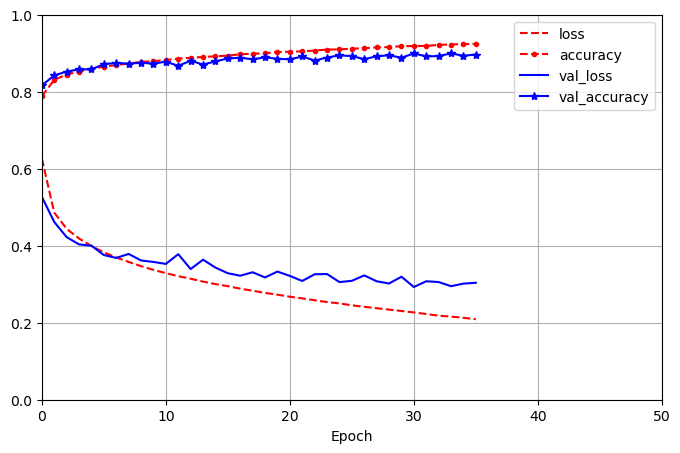

In [51]:
#Visualize learning curves manually
 #Model 1
dnn1_learn_curves = pd.DataFrame(history1.history).plot(
    figsize=(8,5), xlim=[0,epoch_count], ylim=[0,1], grid=True, xlabel="Epoch", style=['r--','r--.','b-','b-*'])
plt.show()

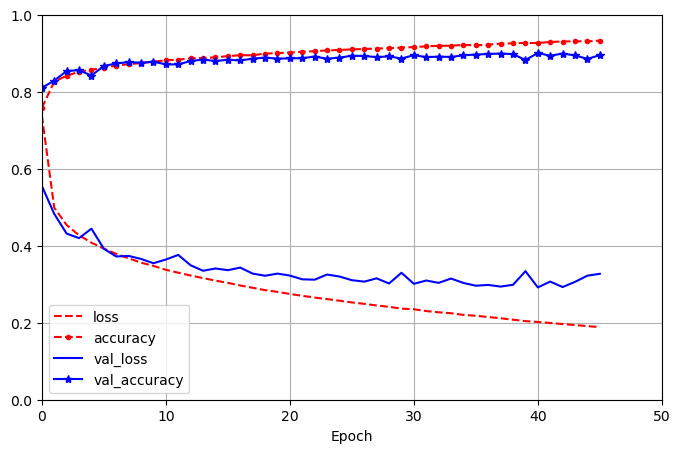

In [52]:
 #Model 2
dnn2_learn_curves = pd.DataFrame(history2.history).plot(
    figsize=(8,5), xlim=[0,epoch_count], ylim=[0,1], grid=True, xlabel="Epoch", style=['r--','r--.','b-','b-*'])
plt.show()

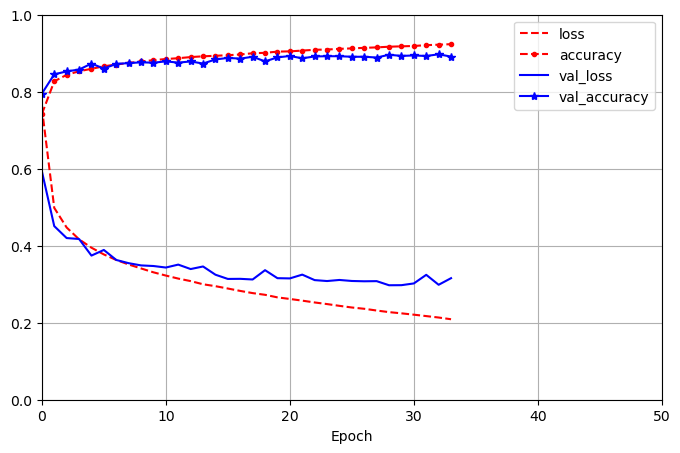

In [53]:
 #Model 3
dnn3_learn_curves = pd.DataFrame(history3.history).plot(
    figsize=(8,5), xlim=[0,epoch_count], ylim=[0,1], grid=True, xlabel="Epoch", style=['r--','r--.','b-','b-*'])
plt.show()

In [56]:
#Display learning curves in TensorBoard
%tensorboard --logdir Tf_output/fit/FMNIST --host localhost

TensorBoard UI: validation accuracies/losses visualized by model and run, with comparison tooltip (screencap; does not function in GitHub)
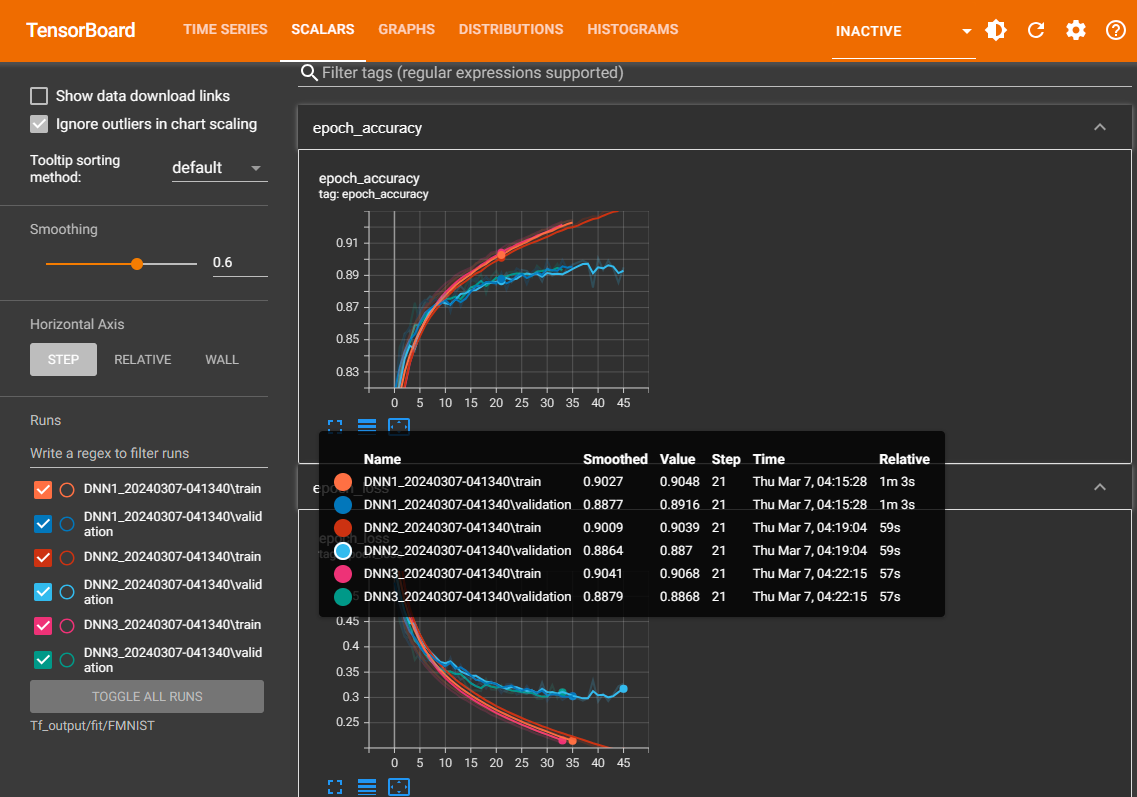

In [58]:
#Load best model for evaluation
best_dnn1 = tf.keras.models.load_model("Tf_output/models/FMNIST/best_dnn1")
best_dnn2 = tf.keras.models.load_model("Tf_output/models/FMNIST/best_dnn2")
best_dnn3 = tf.keras.models.load_model("Tf_output/models/FMNIST/best_dnn3")

In [59]:
#Evaluate best Model 1 on test set
best_dnn1.evaluate(X_te_sc, y_te)

313/313 [==============================] - 0s 1ms/step - loss: 0.2978 - accuracy: 0.8900


[0.29778820276260376, 0.8899999856948853]

In [60]:
 #Verify result with original / non-loaded model
dnn1.evaluate(X_te_sc, y_te)

313/313 [==============================] - 0s 1ms/step - loss: 0.2978 - accuracy: 0.8900


[0.29778820276260376, 0.8899999856948853]

In [61]:
best_dnn2.evaluate(X_te_sc, y_te)

313/313 [==============================] - 0s 1ms/step - loss: 0.3004 - accuracy: 0.8894


[0.30038511753082275, 0.8894000053405762]

In [62]:
best_dnn3.evaluate(X_te_sc, y_te)

313/313 [==============================] - 0s 1ms/step - loss: 0.3069 - accuracy: 0.8863


[0.3069196045398712, 0.8863000273704529]

In [63]:
#Generate + store predictions from model
preds1 = best_dnn1.predict(X_te_sc)
preds2 = best_dnn2.predict(X_te_sc)
preds3 = best_dnn3.predict(X_te_sc)

313/313 [==============================] - 0s 1ms/step


In [64]:
#Review shapes for test label+prediction arrays
 #Prediction array includes one probability per class, for each instance
print(y_te.shape, preds1.shape)
print('Example classwise probabilities:')
pd.DataFrame({'Probabilities': preds1[0]})

(10000,) (10000, 10)
Example classwise probabilities:


,Probabilities
0,0.001114
1,0.005003
2,0.040691
3,0.201129
4,0.633776
5,0.000005
6,0.035286
7,0.000078
8,0.082740
9,0.000178


Instance #: 7029/10,000
True class of instance: tf.Tensor(7, shape=(), dtype=int8) (Sneaker)
Predicted class of instance: 7 (Sneaker)
Model's confidence in prediction: 0.63222873
AxesImage(shape=(28, 28))


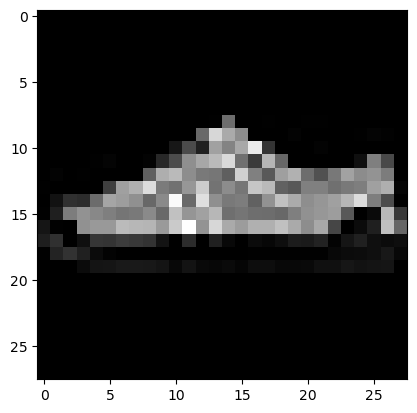

In [65]:
#Sample 3: Compare actual and predicted class for random prediction set instance
 #Select index value for sample
instance_val = random.randint(0,10000)

 #Store values
sample4 = X_te_sc[instance_val]
s4_class_true = y_te[instance_val]
s4_class_pred = np.argmax(preds1[instance_val])
s4_conf = max(preds1[instance_val])

 #Output instance #, true class, predicted class, and prediction confidence for sample
print('Instance #: '+str(instance_val+1)+'/10,000')
print('True class of instance: '+str(s4_class_true)+' ('+class_names[s4_class_true]+')')
print('Predicted class of instance: '+str(s4_class_pred)+' ('+class_names[s4_class_pred]+')')
print('Model\'s confidence in prediction: '+str(s4_conf))

#Display sample 4 image
print(plt.imshow(sample4, cmap='gray'));

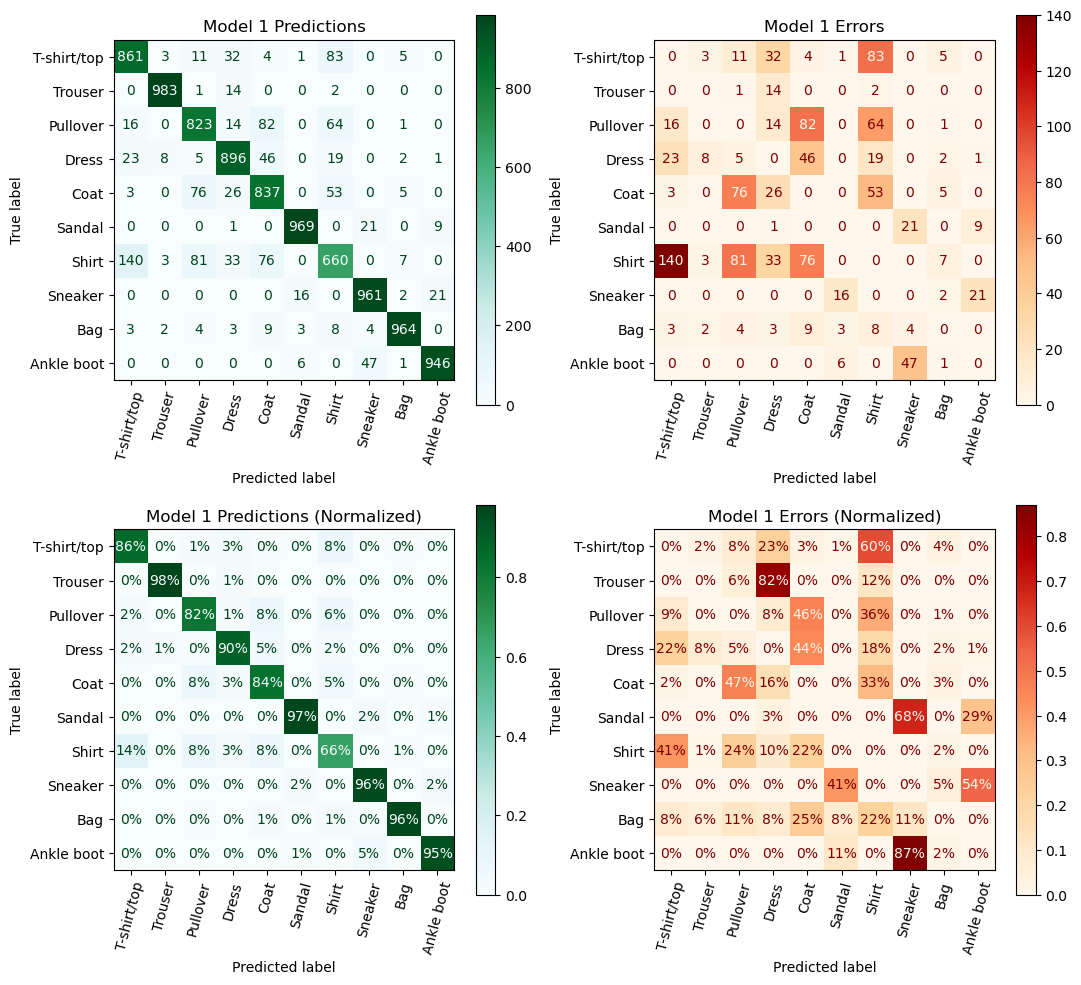

In [66]:
#Confusion Matrices: Model 1
sample_weights1 = (np.argmax(preds1, axis=1) != y_te)

fig, axes = plt.subplots(2, 2, figsize=(11, 10))

 #Format + arrange
  #Matrices 1c + 1d normalized by row
confusion_matrix1a = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1), cmap='BuGn', ax=axes[0, 0], display_labels=class_names, xticks_rotation=75)
axes[0, 0].set_title('Model 1 Predictions')
confusion_matrix1b = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1), cmap='OrRd', ax=axes[0, 1], sample_weight=sample_weights1, display_labels=class_names, xticks_rotation=75)
axes[0, 1].set_title('Model 1 Errors')
confusion_matrix1c = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1), cmap='BuGn', ax=axes[1, 0], values_format='.0%', normalize='true', display_labels=class_names, xticks_rotation=75)
axes[1, 0].set_title('Model 1 Predictions (Normalized)')
confusion_matrix1d = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1), cmap='OrRd', ax=axes[1, 1], values_format='.0%', normalize='true', sample_weight=sample_weights1, display_labels=class_names, xticks_rotation=75)
axes[1, 1].set_title('Model 1 Errors (Normalized)')

 #Display matrices
plt.tight_layout()
plt.show()

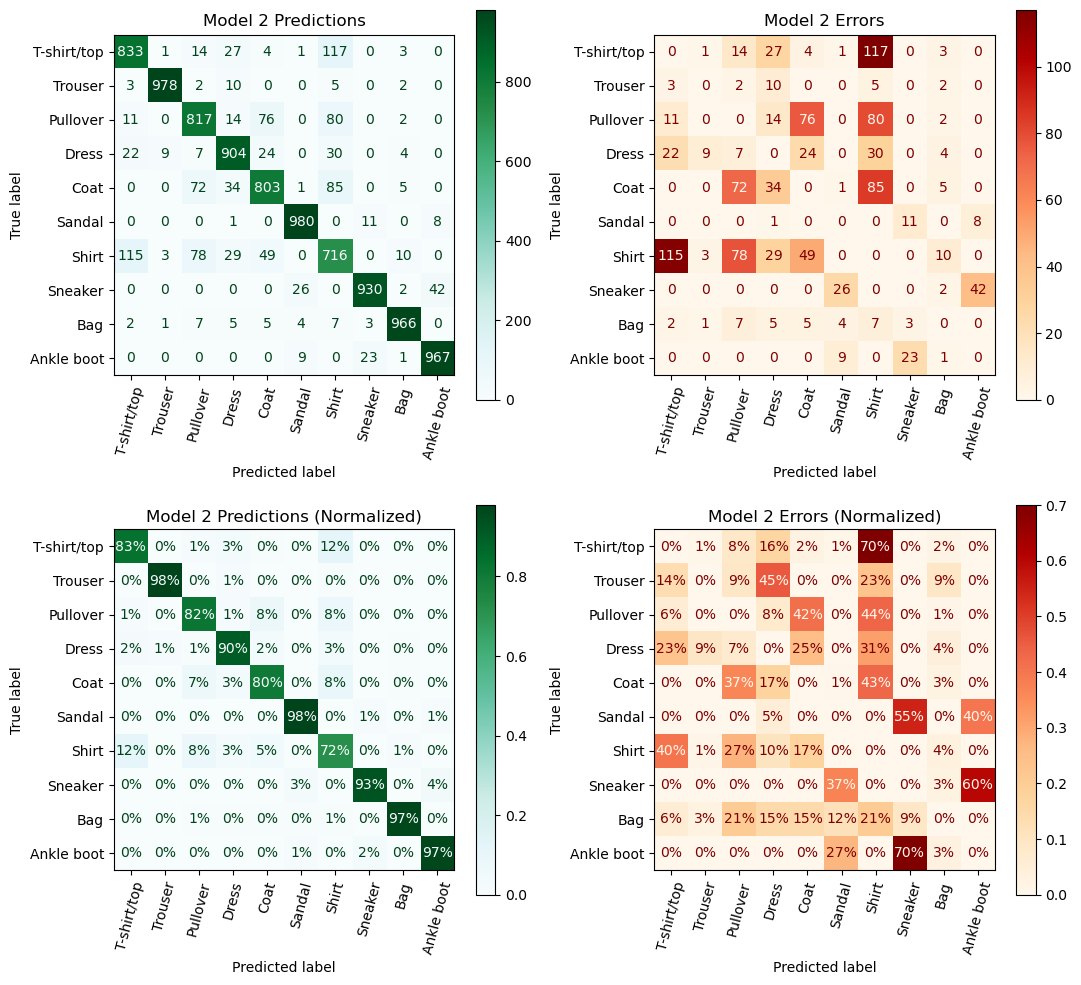

In [67]:
#Confusion Matrices: Model 2
sample_weights2 = (np.argmax(preds2, axis=1) != y_te)

fig, axes = plt.subplots(2, 2, figsize=(11, 10))

 #Format + arrange
  #Matrices 2c + 2d normalized by row
confusion_matrix2a = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds2, axis=1), cmap='BuGn', ax=axes[0, 0], display_labels=class_names, xticks_rotation=75)
axes[0, 0].set_title('Model 2 Predictions')
confusion_matrix2b = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds2, axis=1), cmap='OrRd', ax=axes[0, 1], sample_weight=sample_weights2, display_labels=class_names, xticks_rotation=75)
axes[0, 1].set_title('Model 2 Errors')
confusion_matrix2c = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds2, axis=1), cmap='BuGn', ax=axes[1, 0], values_format='.0%', normalize='true', display_labels=class_names, xticks_rotation=75)
axes[1, 0].set_title('Model 2 Predictions (Normalized)')
confusion_matrix2d = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds2, axis=1), cmap='OrRd', ax=axes[1, 1], values_format='.0%', normalize='true', sample_weight=sample_weights2, display_labels=class_names, xticks_rotation=75)
axes[1, 1].set_title('Model 2 Errors (Normalized)')

 #Display matrices
plt.tight_layout()
plt.show()

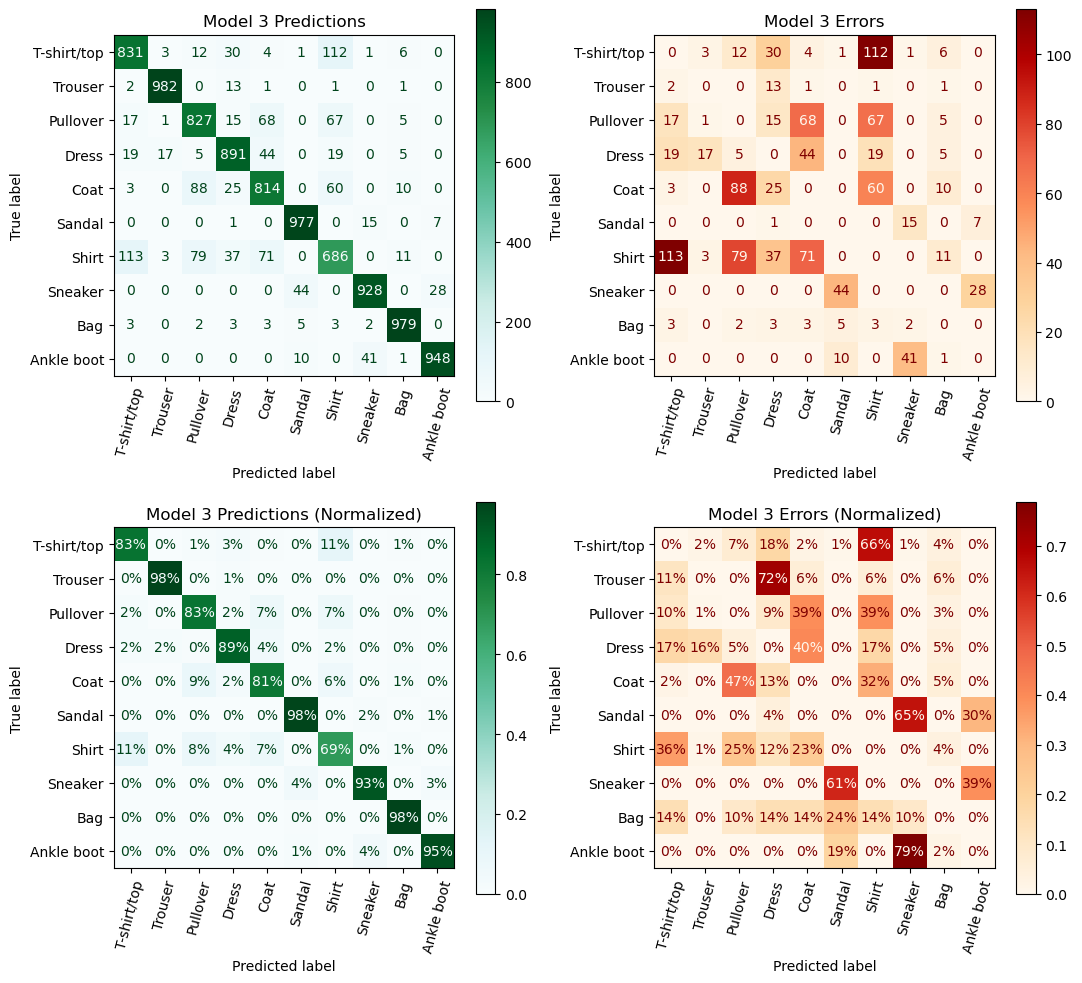

In [68]:
#Confusion Matrices: Model 3
sample_weights3 = (np.argmax(preds3, axis=1) != y_te)

fig, axes = plt.subplots(2, 2, figsize=(11, 10))

 #Format + arrange
  #Matrices 3c + 3d normalized by row
confusion_matrix3a = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds3, axis=1), cmap='BuGn', ax=axes[0, 0], display_labels=class_names, xticks_rotation=75)
axes[0, 0].set_title('Model 3 Predictions')
confusion_matrix3b = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds3, axis=1), cmap='OrRd', ax=axes[0, 1], sample_weight=sample_weights3, display_labels=class_names, xticks_rotation=75)
axes[0, 1].set_title('Model 3 Errors')
confusion_matrix3c = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds3, axis=1), cmap='BuGn', ax=axes[1, 0], values_format='.0%', normalize='true', display_labels=class_names, xticks_rotation=75)
axes[1, 0].set_title('Model 3 Predictions (Normalized)')
confusion_matrix3d = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds3, axis=1), cmap='OrRd', ax=axes[1, 1], values_format='.0%', normalize='true', sample_weight=sample_weights3, display_labels=class_names, xticks_rotation=75)
axes[1, 1].set_title('Model 3 Errors (Normalized)')

 #Display matrices
plt.tight_layout()
plt.show()

**Development Notes**

<u>Data Engineering process<u/>
- Imported full csv data to DataFrame
  - Sample 1a: randomly sampled data instance; reshaped, identified class/category, and displayed image
- Converted and reshaped df to 1- (labels) and 3-dimensional (features) ndarrays
  - Sample 1b: re-located 1a by index; identified, and displayed image
- Evaluated two methods for splitting data while preserving dataset balance; selected sklearn over keras method for precise stratification
  - Performed train/validation/test data splits
- Scaled data to optimize for gradient descent
- Converted numpy arrays to Tensorflow tensors
  - Provides GPU support (not supported in Windows), computational graphs for parallelization, gradient tape for auto-differentiation
  - Sample 2: accessed new instance from tensor (instances re-indexed by splitting); identified, and displayed image
- Reduced precision/bit depth of tensors to reduce memory use and computational cost
- Sample 3: randomly sampled test set; compared model prediction to ground truth label, output prediction confidence, and displayed image

<u>Model Evaluation<u/>

**NOTE: Evaluated within trial; results must be aggregated across trials for meaningful comparison**

<u>Model 1<u/>
- Initial 'Wide' baseline model
- Training
  - Training accuracy exceeding validation accuracy after ~Epoch 5 indicates some overfitting
- Overall Accuracy achieved: ~0.89-0.90
  - Highest for Trousers, Sandals, Sneakers, Bags, and Ankle Boots (95%+)
  - Lowest for T-shirt/tops, Pullovers, Dresses, Coats, Shirts (~70-90%)
    - 'Shirts' are particularly difficult to correctly classify (~70%)
- Has the most difficulty distinguishing between clothing shapes made for upper-body, listed above
  - Understandable, due to similarities/ambiguity

 <u>Model 2<u/>
- Built model with same # neurons & layers, rearranged into uniform shape (rather than tapering)
  - Compared to Model 1, relatively negligible effect on performance
    - Minute decrease in training accuracy/increase in validation accuracy
    - Wider first dense layer may be better suited to 784 feature input layer

<u>Model 3<u/>
- 'Deep' model; increased network depth (keeping total neurons constant)
  - Anticipated improved higher-order image feature identification (i.e., improved accuracy for difficult categories)
    - Performance did not significantly improve; in fact, decreased slightly

<u>Model 4<u/>
- Utilize neuron dropout layer to improve generalization/reduce overfitting

<u>Model 5<u/>
- Build wide and deep model